# Transter Learning with Tensorflow Part 1: Feature Extraction

Transfer learning is leverage an existing neural network architecture proven to work on problem similar to our own.

there are two main benefits:
1. can leverage an existing neural network architecture proven to work on problems similar to our own .

2. can leverage a working neural network architecture which has already learned pattern on similar data to our own, then we can adapt those patterns to our own data.

In [20]:
!nvidia-smi

Mon Nov 21 09:11:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |   7608MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming ine with the data

In [21]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file 
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-11-21 09:11:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  23.0MB/s    in 7.9s    

2022-11-21 09:11:17 (20.3 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [22]:
# how many images in each folder?
import os

# walk throught 10 precent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 2 directories and 0 images in '10_food_classes_10_percent'.
there are 10 directories and 0 images in '10_food_classes_10_percent/train'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
there are 0 directories and 75 images in '10_food_classes_10_percent/tra

## create data loader (preparing the data)

we'll use the `ImageDataGenertor` class to load in our images in batches.

In [23]:
# setup data input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (2242,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("training images :")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("testing images :")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

training images :
Found 750 images belonging to 10 classes.
testing images :
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callback:
* Tracking experiment with the **TensorflowBoard callback**
* Model checkpoint with the **ModelCheckpoint callback**
*Stopping a model from training (before it trains too long and overfits) with the **EarlyStopping callback**

In [24]:
# create Tensorflow callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

> 🔑**NOTE:** you can customize the directory where your TensorBoard logs  (model training metrics) get saved to whatever you like.
the ` log_dir` parameter we've created above is only one option.

## Creating models using Tensorflow Hub

in the past we've used Tensorflow to create our models layer from scratch.

Now we're going to do a similar process,except the majroity of our models layers are going to come from TensorFlow Hub.

we can access pretrained models on :https://tfhub.dev/
Browsing the tensorflow hub page and sorting for image classifcation , we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [38]:
# let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url ="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [26]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [27]:
IMAGE_SHAPE+(3,)

(2242, 224, 3)

In [28]:
# let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """ 
  Tackes a Tesnorflow Hub URL and create a keras Sequential model with it .
  

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer
      should be equal to number of target classes , defult 10.

  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor 
    layer and Dense output kayer with num_classes output neurons.

  """

  # Download the pretrained model and save it as a keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable=False,# freeze already learned pattern
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,))
  


  # create our own model
  model = tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(num_classes, activation="softmax",name="output_layer")
  ])

  return model

## create and testing RseNet TensorFlow Hub Extraction model

In [29]:
# create Resnet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [30]:
# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [31]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [32]:
# lets fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

saving TensorBoard log files to : tensorflow_hub/resnet50v2/20221121-091121
Epoch 1/5
24/24 [==============================] - 85s 3s/step - loss: 2.2351 - accuracy: 0.2067 - val_loss: 2.0636 - val_accuracy: 0.2944
Epoch 2/5
24/24 [==============================] - 83s 4s/step - loss: 1.8733 - accuracy: 0.4080 - val_loss: 1.7508 - val_accuracy: 0.4524
Epoch 3/5
24/24 [==============================] - 84s 4s/step - loss: 1.6289 - accuracy: 0.4813 - val_loss: 1.6312 - val_accuracy: 0.4768
Epoch 4/5
24/24 [==============================] - 84s 4s/step - loss: 1.4772 - accuracy: 0.5600 - val_loss: 1.5438 - val_accuracy: 0.5044
Epoch 5/5
24/24 [==============================] - 84s 4s/step - loss: 1.3560 - accuracy: 0.6080 - val_loss: 1.4534 - val_accuracy: 0.5440


WoW!
That. Is Incredible. Our transfer learning feature extraction model performed ALL of the previous models we bulit by hand... (substantially)
and in quicker training time AND with only 10% of the training examples. 

In [36]:
# lets create a function to plot our loss curves
# Tibdit :you could put a function like this into script called "helper.py" and import it when  you need it...
import matplotlib.pyplot as plt

# plot the validation and training curves
def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics.

  Arg :
    history: TensorFlow History object .

  
  Returns:
    plots of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss,label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # plot accuracy 
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

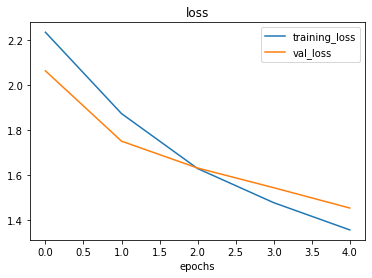

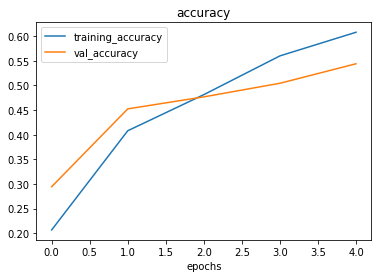

In [37]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 Tensorfllow Hub Feature Extraction model

In [45]:
# create EfficientNetB0 feature extraction model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

#compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# fit EfficeintNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientnetb0")])

saving TensorBoard log files to : tensorflow_hub/efficientnetb0/20221121-095829
Epoch 1/5
24/24 [==============================] - 69s 3s/step - loss: 2.2346 - accuracy: 0.1813 - val_loss: 2.0787 - val_accuracy: 0.3028
Epoch 2/5
24/24 [==============================] - 58s 3s/step - loss: 1.9564 - accuracy: 0.3840 - val_loss: 1.9079 - val_accuracy: 0.4020
Epoch 3/5
24/24 [==============================] - 59s 3s/step - loss: 1.7902 - accuracy: 0.4667 - val_loss: 1.7585 - val_accuracy: 0.4772
Epoch 4/5
24/24 [==============================] - 59s 3s/step - loss: 1.6634 - accuracy: 0.5227 - val_loss: 1.6724 - val_accuracy: 0.5040
Epoch 5/5
24/24 [==============================] - 96s 4s/step - loss: 1.5566 - accuracy: 0.5587 - val_loss: 1.5916 - val_accuracy: 0.5248


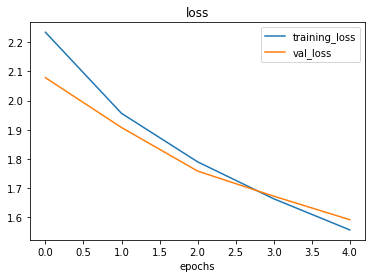

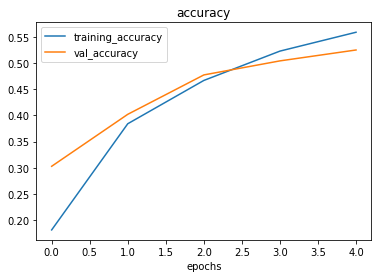

In [46]:
plot_loss_curves(efficientnet_history)

In [47]:
len(efficientnet_model.layers[0].weights)

309

## Different  types of transfer learning 

* **"As is"transfer learning** -using an existing model with no change what so ever(e.g using ImageNet model on 1000 ImageNet classes, none of your own)

* **"Feature Extraction"** transfer learning -use the perlearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes of food)

* **"Fine-tuning" transfer learning** -use the perlearned pattern of an existing model and "fine-tune" many or all of the underlying layers (includevnew output layers)

## comparing our models result using TesorBoard

> 🔑**Note:** when you upload thing in TensorBoard.dev, you experiments are  public.so if you're running private experiment (things you don't want other to see) dont upload them to TensorBoard.dev

In [49]:
# upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "efficientnetB0 vs. Resnet50v2" \
  --description "comparing two fifferent TF Hub feature extraction model architecture" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=tZKGCptPHcGj960EgFuGhgQ41axow7&prompt=consent&access_type=off

In [50]:
!tensorboard dev list

https://tensorboard.dev/experiment/6pwHjnw3QpKV7Knf159S2A/
	Name                 efficientnetB0 vs. Resnet50v2
	Description          comparing two fifferent TF Hub feature extraction model architecture
	Id                   6pwHjnw3QpKV7Knf159S2A
	Created              2022-11-21 12:12:51 (7 minutes ago)
	Updated              2022-11-21 12:12:58 (7 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  7768382
Total: 1 experiment(s)


In [51]:
# delete an experiment
# !tensorboard dev delete --experiment_id 